## Policy gradient algorithms for Reinforcement Learning

This notebook has been created using the lessons learnt from the CS294 Deep Reinforcement Learning course from UC Berkeley, whose videos are available [online](http://rail.eecs.berkeley.edu/deeprlcourse-fa17/index.html). The problem presented here uses the famous Cart Pole problem from the well-known [Open AI Gym](https://gym.openai.com/). The selected toy problem has an observation space of size 4 in a continuouis domain while actions are discrete (i.e. only two available actions).

Other repositories, such as [this](https://gist.github.com/shanest/535acf4c62ee2a71da498281c2dfc4f4) or [this](https://github.com/dennybritz/reinforcement-learning/blob/master/PolicyGradient/CliffWalk%20REINFORCE%20with%20Baseline%20Solution.ipynb) have been used as support for creating this notebook.

## Needed imports

In [1]:
import numpy as np
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## Agent class

The agent uses a small neural network as policy function, which is updated using gradient descent. In the context of policy gradient algorithms, observations and states are used indistinctly.

In [2]:
class Agent(object):
    
    """
    Agent that is playing with the environment using policy
    gradient algorithm
    """
    
    def __init__(self,
                 state_size: int,
                 num_actions: int,
                 hidden_sizes: [],
                 hidden_activations=tf.nn.relu,
                 **params):
        """
        Initializes an agent that must act according to the environment
        using gradient-based policy (i.e. neural network)
        """
        self._sess = tf.Session()
        self._state_size = state_size
        self._num_actions = num_actions
        self._hidden_sizes = hidden_sizes
        self._hidden_activations = hidden_activations
        self._policy_op = self._define_policy_op()
        self._update_op = self._define_policy_update_op(**params)
        self._sample_op = self._define_sample_op()
        self._sess.run(tf.global_variables_initializer())
    
    def _define_policy_op(self):
        """
        Returns the logits of the network as a non-normalized
        probability distribution over the available actions
        """
        self._initialize_placeholders()
        # Build provided hidden layers
        hidden = self._state_placeholder
        for layer_size in self._hidden_sizes:
            hidden = tf.layers.dense(
                hidden, units=layer_size, activation=self._hidden_activations
            )
        # Output layer
        return tf.layers.dense(
            hidden, units=self._num_actions, activation=None
        )
    
    def _define_policy_update_op(self, **params):
        """
        Returns Tensorflow operation to minimize in a way that it
        maximizes the probability of getting high rewards when taking
        actions from the output of the network
        """
        # Compute log of output probability distribution
        self._logs_prob = tf.log(tf.nn.softmax(self._policy_op))
        # Select only chosen sampled policy actions
        indices = tf.range(0, tf.shape(self._policy_op)[0])
        sampled_action_idxs = tf.stack([indices, self._action_placeholder], axis=1)
        self._action_logs_prob = tf.gather_nd(self._logs_prob, sampled_action_idxs)
        # Loss as mean of the weighted log probability of all game iterations
        self._loss_op = -tf.reduce_sum(tf.multiply(self._action_logs_prob, self._reward_placeholder))
        optimizer = tf.train.RMSPropOptimizer(params.get('learning_rate', 1e-2))
        return optimizer.minimize(self._loss_op)

    def _define_sample_op(self):
        """
        Returns a Tensorflow operation that provides, given an input state,
        a sampled action according to the unnormalized output probabilities
        """
        return tf.multinomial(self._policy_op, num_samples=1)
    
    def _initialize_placeholders(self):
        self._state_placeholder = tf.placeholder(
            dtype=tf.float32, shape=[None, self._state_size]
        )
        self._reward_placeholder = tf.placeholder(dtype=tf.float32)
        self._action_placeholder = tf.placeholder(dtype=tf.int32)
    
    def sample_action(self, state: np.array) -> int:
        """
        Samples an action according to the current trained policy
        """
        return self._sess.run(
            self._sample_op,
            feed_dict={self._state_placeholder: np.expand_dims(state, axis=0)}
        )[0][0]
    
    def update(self, states, rewards, actions):
        """
        Updates the policy function using the gradient towards
        maximizing the reward
        """
        reward_array = np.asarray(rewards)
        adjusted_reward = reward_array - np.mean(reward_array)
        # Run reward maximization op
        _, loss, a, b = self._sess.run(
            [self._update_op, self._loss_op, self._action_logs_prob, self._logs_prob],
            feed_dict={
                self._state_placeholder: np.asmatrix(states),
                self._reward_placeholder: adjusted_reward,
                self._action_placeholder: np.asarray(actions)
            }
        )

    def finish(self):
        """
        Releases resources needed by the agent
        """
        self._sess.close()

## Game environment class

We create a class that represents the world the agent interacts with

In [3]:
class Game(object):

    def __init__(self, output_folder=None):
        """
        Initializes the "world" in the Reinforcement Learning problem
        Args:
            output_folder: If provided, folder where to store training
                procedures. 
        """
        self._env = gym.make("CartPole-v0")
        if output_folder is not None:
            self._env = gym.wrappers.Monitor(self._env, output_folder, force=True)
    
    @property
    def state_space(self) -> int:
        # In policy gradient algorithms, we can use observations
        # and states indistinctly
        return self._env.observation_space.shape[0]
    
    @property
    def action_space(self) -> int:
        return self._env.action_space.n
    
    def _play_single_game(self,
                          agent: Agent,
                          max_game_iterations: int,
                          render: bool = False):
        """
        Plays a single game in the environment. Returns lists of
        states, rewards and actions as well as the number of steps
        survided for the game played.
        """
        states, rewards, actions = [], [], []
        initial_state = self._env.reset()
        step, finished = 0, False
        prev_state = initial_state
        while not finished:
            if render:
                self._env.render()
            # Store current state
            states.append(prev_state)
            # Sample action and apply it
            current_action = agent.sample_action(prev_state)
            state, reward, done, _ = self._env.step(current_action)
            # Store reward and action
            rewards.append(reward)
            actions.append(current_action)
            # Keep previous state
            prev_state = state
            # Update end condition
            step += 1
            finished = done or step >= max_game_iterations
        return states, self._process_reward(rewards), actions, step

    
    def train(self,
              agent: Agent,
              n_iterations: int,
              min_batch_size: int,
              max_game_iterations: int):
        """
        Trains the input agent for the given number of iterations in the
        Cart Pole game. Returns the mean steps "survided" per iteration
        """
        mean_iteration_steps = []
        for iteration in range(n_iterations):

            # Initialize stats for current iteration
            iteration_steps = []
            total_states, total_rewards, total_actions = [], [], []
            
            # Each iteration corresponds to training a batch
            while len(total_rewards) < min_batch_size:
                states, rewards, actions, steps = game._play_single_game(agent, max_game_iterations)
                total_states += states
                total_rewards += rewards
                total_actions += actions
                iteration_steps.append(steps)

            # Track stats about how much the agent lasted in the game
            mean_survided_steps = np.mean(iteration_steps)
            mean_iteration_steps.append(mean_survided_steps)
            print(
                "Finished iteration %d. Mean survided steps: %f" %
                (iteration, mean_survided_steps)
            )
                
            # Batch is big enough, let's update the policy
            agent.update(total_states, total_rewards, total_actions)
        
        return mean_iteration_steps
    
    @staticmethod
    def _process_reward(rewards: []) -> []:
        """
        Converts a list of episodic rewards into rewards
        Taken from: https://gist.github.com/shanest/535acf4c62ee2a71da498281c2dfc4f4
        """
        return [len(rewards)] * len(rewards)
    
    def close(self):
        self._env.close()

## Training the agent

Let's see what happens if we run the game without any learning (i.e. learning rate of 0)

In [4]:
def plot_step_evolution(steps: []):
    plt.plot(steps)
    plt.xlabel("Iterations")
    plt.ylabel("Steps alive")

[2018-08-19 19:44:49,332] Making new env: CartPole-v0


Finished iteration 0. Mean survided steps: 19.454545
Finished iteration 1. Mean survided steps: 17.166667
Finished iteration 2. Mean survided steps: 17.666667
Finished iteration 3. Mean survided steps: 22.888889
Finished iteration 4. Mean survided steps: 16.846154
Finished iteration 5. Mean survided steps: 15.384615
Finished iteration 6. Mean survided steps: 19.545455
Finished iteration 7. Mean survided steps: 17.333333
Finished iteration 8. Mean survided steps: 17.250000
Finished iteration 9. Mean survided steps: 17.666667
Finished iteration 10. Mean survided steps: 18.272727
Finished iteration 11. Mean survided steps: 13.466667
Finished iteration 12. Mean survided steps: 18.923077
Finished iteration 13. Mean survided steps: 19.090909
Finished iteration 14. Mean survided steps: 14.000000
Finished iteration 15. Mean survided steps: 20.200000
Finished iteration 16. Mean survided steps: 16.230769
Finished iteration 17. Mean survided steps: 14.333333
Finished iteration 18. Mean survided s

Finished iteration 152. Mean survided steps: 16.750000
Finished iteration 153. Mean survided steps: 14.642857
Finished iteration 154. Mean survided steps: 20.200000
Finished iteration 155. Mean survided steps: 15.538462
Finished iteration 156. Mean survided steps: 15.923077
Finished iteration 157. Mean survided steps: 17.416667
Finished iteration 158. Mean survided steps: 17.416667
Finished iteration 159. Mean survided steps: 13.400000
Finished iteration 160. Mean survided steps: 17.250000
Finished iteration 161. Mean survided steps: 24.800000
Finished iteration 162. Mean survided steps: 18.333333
Finished iteration 163. Mean survided steps: 19.000000
Finished iteration 164. Mean survided steps: 20.400000
Finished iteration 165. Mean survided steps: 18.166667
Finished iteration 166. Mean survided steps: 16.461538
Finished iteration 167. Mean survided steps: 26.555556
Finished iteration 168. Mean survided steps: 18.454545
Finished iteration 169. Mean survided steps: 14.357143
Finished i

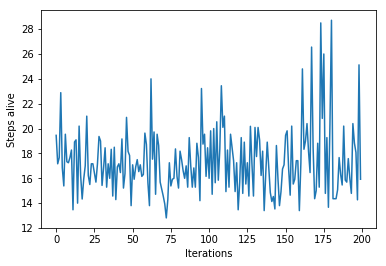

In [5]:
game = Game()
agent = Agent(
    state_size=game.state_space,
    num_actions=game.action_space,
    hidden_sizes=[64],
    learning_rate=0.0
)
steps_over_time = game.train(
    agent,
    n_iterations=200,
    min_batch_size=200,
    max_game_iterations=300
)
plot_step_evolution(steps_over_time)

In [8]:
from IPython.display import HTML

HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="resources/1_Policy_Gradients/non_trained.mp4" type="video/mp4">
</video></div>""")

Taking a look at the last plot, which shows the evolution of steps the agent is "alive" in the environment, we can see that sampling from a non-trained policy (i.e. initialized using random weights) results in a random time series. Let's see what happens if we use a learning rate higher than 0 (note that the number of maximum steps allowed in the environment is 200 by default):

[2018-08-19 19:45:13,434] Making new env: CartPole-v0


Finished iteration 0. Mean survided steps: 17.285714
Finished iteration 1. Mean survided steps: 41.600000
Finished iteration 2. Mean survided steps: 17.416667
Finished iteration 3. Mean survided steps: 26.500000
Finished iteration 4. Mean survided steps: 31.000000
Finished iteration 5. Mean survided steps: 60.750000
Finished iteration 6. Mean survided steps: 36.500000
Finished iteration 7. Mean survided steps: 42.600000
Finished iteration 8. Mean survided steps: 49.800000
Finished iteration 9. Mean survided steps: 36.166667
Finished iteration 10. Mean survided steps: 101.666667
Finished iteration 11. Mean survided steps: 48.200000
Finished iteration 12. Mean survided steps: 64.250000
Finished iteration 13. Mean survided steps: 58.250000
Finished iteration 14. Mean survided steps: 84.333333
Finished iteration 15. Mean survided steps: 120.500000
Finished iteration 16. Mean survided steps: 76.000000
Finished iteration 17. Mean survided steps: 103.666667
Finished iteration 18. Mean survide

Finished iteration 149. Mean survided steps: 200.000000
Finished iteration 150. Mean survided steps: 200.000000
Finished iteration 151. Mean survided steps: 200.000000
Finished iteration 152. Mean survided steps: 200.000000
Finished iteration 153. Mean survided steps: 200.000000
Finished iteration 154. Mean survided steps: 200.000000
Finished iteration 155. Mean survided steps: 200.000000
Finished iteration 156. Mean survided steps: 200.000000
Finished iteration 157. Mean survided steps: 200.000000
Finished iteration 158. Mean survided steps: 200.000000
Finished iteration 159. Mean survided steps: 200.000000
Finished iteration 160. Mean survided steps: 200.000000
Finished iteration 161. Mean survided steps: 200.000000
Finished iteration 162. Mean survided steps: 200.000000
Finished iteration 163. Mean survided steps: 200.000000
Finished iteration 164. Mean survided steps: 200.000000
Finished iteration 165. Mean survided steps: 200.000000
Finished iteration 166. Mean survided steps: 200

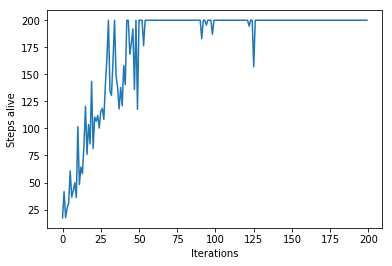

In [6]:
game = Game()
agent = Agent(
    state_size=game.state_space,
    num_actions=game.action_space,
    hidden_sizes=[64],
    learning_rate=1e-2
)
steps_over_time = game.train(
    agent,
    n_iterations=200,
    min_batch_size=200,
    max_game_iterations=300
)
plot_step_evolution(steps_over_time)

In [9]:
from IPython.display import HTML

HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="resources/1_Policy_Gradients/trained.mp4" type="video/mp4">
</video></div>""")

It is clear that the agent improves its performance over time.

In [10]:
agent.finish()
game.close()

## Playground

Even if this is a easy learning to automatize, the tuning of the hyperparameters can be complex. Here ideas of what you can modify to see how the behavior of the agent changes:

* Learning rate
* Gradient optimizer
* Number of layers in the neural network
* Size of the neural network layers
* Activation function in the hidden layers of the neural network
* Number of iterations per batch
* Normalization of the rewards (baseline)
* ...